# Task 1: Simulating Fisher-Wright

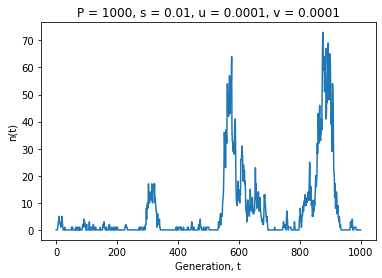

In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
from functools import partial

rng = np.random.default_rng()

def psm(n, P, s, u, v):
    """We heavily reuse this"""
    ps = (1+s)*n/(P+n*s)
    return (1-v)*ps + u*(1-ps)

def updateFW(n, P, s, u, v):
    """Generate a new population of size P starting with n individuals of type B"""
    return rng.binomial(P, psm(n, P, s, u, v))

class FisherWright():
    """Simulate the Dynamics of the Fisher-Wright Model
    We create an iterator to this"""
    
    def __init__(self, param):
        "create a function with the parameter set apart form n"
        self.update = partial(updateFW, **param)
        
    def __iter__(self):
        n = self.n0
        #this is just for lazy evaluation, I think?
        yield n
        while True:
            n = self.update(n)
            yield n

    def __call__(self, n0):
        """initiate n0 and return iterator"""
        self.n0 = n0
        return iter(self)

param = {"P": 1000, "s": 0.01, "u": 0.0001, "v": 0.0001}

fisherWright = FisherWright(param)

T = 10000

#returns a tuple list of data points of the generation number and the value of n(t)
def evolution(model, n0, T, transform=lambda x: x):
    """Run the model for T generations starting from n0
        transform the output of the model with default of doing nothing"""
    it = model(n0)                # create a new iterator
    return [(i, transform(next(it))) for i in range(T)]

#wrap the code to run and show the results of the fisher wright evolution into a resusable function
def show_FW(nGens):
    
    #
    evo = evolution(fisherWright, 0, nGens)
    
    def dict_to_str(dic):
        return ", ".join([f"{key} = {value}" for (key,value) in param.items()])

    plt.plot(*zip(*evo))        # weird trick to get matplotlib to plot a list of (x,y) pairs
    plt.xlabel("Generation, t")
    plt.ylabel("n(t)")
    plt.title(dict_to_str(param))
    plt.show()

show_FW(1000)

## Task 1 Questions

1. Under what conditions does trait B take over the population

Trait B takes over the population if there is a balance in the forward/backward mutation rates u and v such that v is below a certain amount and u is large enough  meaning the forward7 mutations outweigh the backward mutatoins, provided the population is a sufficiently large size.

2. Take-over time investigations depending on various factors

First we need to define a function that calculates in what number generation trait B has taken over the population, we simply iterate through the populations generated by the model keeping a count of what generation we are on and return the number generation where the proportion of B traited individuals is >= 0.95:

In [7]:
def calc_takeover_time(param_dict):
    
    model = FisherWright(param_dict)
    
    #lets take the initial generation number to always be 0
    for gen_num, val in enumerate(model(0)):
        
        if(val >= 0.95 * param_dict['P']):
            return gen_num

2a. Investigate how different values of the selection strength (s) affects takeover time:

In [142]:
def investigate_s_dependance():
    
    #the s value will be timesed by 10 on each iteration
    params = {'P': 10000, 's': 0.0001, 'u': 0.0001, 'v': 0.0001}
    
    #tuples of the s value paired with the takeover time
    data_points = []
    
    for i in range(800):
        
        #record the value of s and the takeover time
        data_points.append((params['s'], calc_takeover_time(params)))
        #params['s'] *= 10
        params['s'] += 0.0001
    
    plt.plot(*zip(*data_points))
    plt.xlabel("Selection strength (s), log scale")
    plt.ylabel("Takeover time, log scale")
    plt.yscale("log")
    plt.xscale("log")
    plt.title("How takover time varies depending on different s values")
    plt.show()

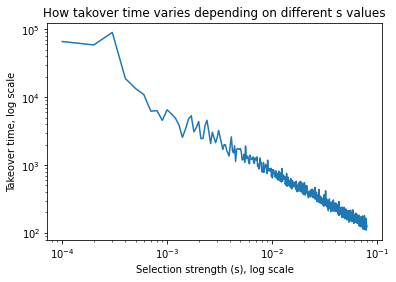

In [143]:
investigate_s_dependance()

2b. Investigate how different values of mutation (such that forwards mutation and backwards mutation variables are the values we change on each iteration but they are always equal to each other) affects takeover time:

In [133]:
def investigate_mut_dependance():
    
    #the u and v vals will be incremented by 0.00001 on each iteration
    params = {'P': 10000, 's': 0.01, 'u': 0.00001, 'v': 0.00001}
    
    #tuples of the m value paired with the takeover time
    data_points = []
    
    for i in range(155):
                
        #u and v will always be the same so just pick either
        data_points.append((params['u'], calc_takeover_time(params)))
        params['u'] += 0.00001
        params['v'] += 0.00001
    
    plt.plot(*zip(*data_points))
    plt.xlabel("Mutation rate (m), linear scale")
    plt.ylabel("Takeover time, log scale")
    plt.yscale("log")
    plt.title("How takover time varies depending on the mutation rate")
    plt.show()
    #return data_points

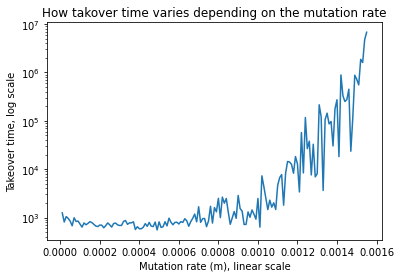

In [134]:
data_points = investigate_mut_dependance()

### Mutation rate effect on takeover time observation

Changing the mutation rate had a very interesting effect on the population, and if you think about it it makes sense. On each iteration we are keeping both the forward AND backward mutation rates the same meaning they will sort of cancel one another out; in fact, when investigating over a certain number of iterations (around 160, which is why I have kept it at 155, each iteration increments the mutation rate by 0.00001 where the mutation rate on the initial iteration is also 0.00001) I found that the algorithm never even finished (or took much longer than my computer could handle) as clearly the rate of an individual in the population mutating to the other trait (either an A individual mutating to a B individual or a B individual mutating to an A individual) became so large that a sort of "equilibrium" state is reached in the population and it becomes extremely unlikely for one trait to take over the population due to huge numbers of both B individuals and A individuals appearing in subsequence generations. I believe the data on the graph supports my hypothesis due to the fluctuating, but increasing takeover time through subsequent generations.

2c. Investigate how changing the population size P affects takeover time:

In [158]:
def investigate_P_dependance():
    
    #the P value will be timesed by 10 on each iteration
    params = {'P': 100, 's': 0.01, 'u': 0.0001, 'v': 0.0001}
    
    #tuples of the P value paired with the takeover time
    data_points = []
    
    for i in range(15):
        
        #u and v will always be the same so just pick either
        data_points.append((params['P'], calc_takeover_time(params)))
        params['P'] *= 10
    
    plt.plot(*zip(*data_points))
    plt.xlabel("Population size (P), log scale")
    plt.ylabel("Takeover time, linear scale")
    #plt.yscale("log")
    plt.xscale("log")
    plt.title("How takover time varies depending on the population size")
    plt.show()

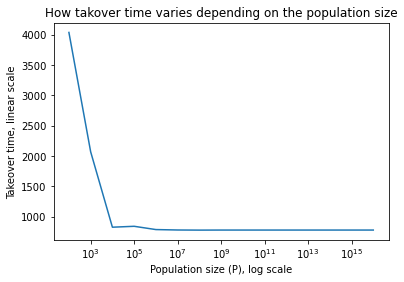

In [159]:
investigate_P_dependance()

# Task 2: Multiple runs

In [ ]:
#assume a model is something that when run, returns a list of tuples
#where the first element of each tuple is the number generation
#and the second element is some value
def multiple_runs(model, n_runs)

    